[Solution_Blog_Reference](https://www.kaggle.com/asrsaiteja/game-data-analysis)<br>
[Exact_Question_Reference](https://community.dataquest.io/t/i-want-a-hint-or-a-solution-for-a-problem-statement-as-to-how-to-approach-it/551295)

In [1]:
# https://www.kaggle.com/asrsaiteja/game-data-analysis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('ggplot')

In [2]:
file_path = 'level_progress.csv'

df = pd.read_csv(file_path, parse_dates = ['event_datetime'])
df.shape, df.columns

((55826, 5),
 Index(['event_datetime', 'player_id', 'level_number', 'status', 'session_id'], dtype='object'))

In [3]:
df.head()

,event_datetime,player_id,level_number,status,session_id
0,2020-11-28 21:00:24.958,00020eac3d7e4f058b87eac1a9a85c25,6,complete,6ddf006b807e451eb4706d6d98a049b6
1,2020-11-27 22:03:03.048,00020eac3d7e4f058b87eac1a9a85c25,2,start,3ba98db705f2aa0bc406441a61c23b3c
2,2020-11-26 14:53:09.344,002188c0bc476f356f4c3b74e5cc66c8,1,start,25cf292a8f1d3da01df8371276502edf
3,2020-12-03 11:43:26.582,00576ef3617e6bbbabfa0b1090e4122d,1,start,21fd6a7db53a9220574563ac8a8c8b58
4,2020-12-04 14:23:07.448,00576ef3617e6bbbabfa0b1090e4122d,7,start,358b9ab5c1c0f08bc7def310411eb90f


In [4]:
df.apply(lambda x : len(x.unique()))

event_datetime    55826
player_id          3872
level_number         50
status                3
session_id        12759
dtype: int64

In [5]:
avg_session_per_player = df.groupby('player_id')['session_id'].nunique().mean()
avg_levels_per_session = df.groupby('session_id')['level_number'].nunique().mean()
print('Average sessions by a player:', avg_session_per_player)
print('Average (different) levels in a session:', avg_levels_per_session)

Average sessions by a player: 3.2951962809917354
Average (different) levels in a session: 2.3004937691041616


Session: from the point a user open the game to exit's it.
    
So, in a single session, user can play multiple levels.

From the given data, It seems like user can start any level he wants,
bcz there are events of next level without completing the current level with in same session.

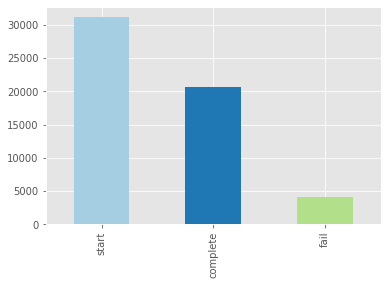

In [6]:

df['status'].value_counts().plot(kind = 'bar', color=plt.cm.Paired(np.arange(3)))

It is clear that start events are more than sum of complete + fail events, <br>
so there are cases where the level has started but resulted in neither success nor fail.<br> 
So user might have left the game ?<br>

Start events only represents the start of the level,<br>
not outcome so these are not need to be accounted to calculate the rate of success/failure.<br>

If a user left(s) a game/level in middle, can he resume from where he left off ? I dont think so.

status
complete    AxesSubplot(0.125,0.125;0.775x0.755)
fail        AxesSubplot(0.125,0.125;0.775x0.755)
start       AxesSubplot(0.125,0.125;0.775x0.755)
Name: player_id, dtype: object

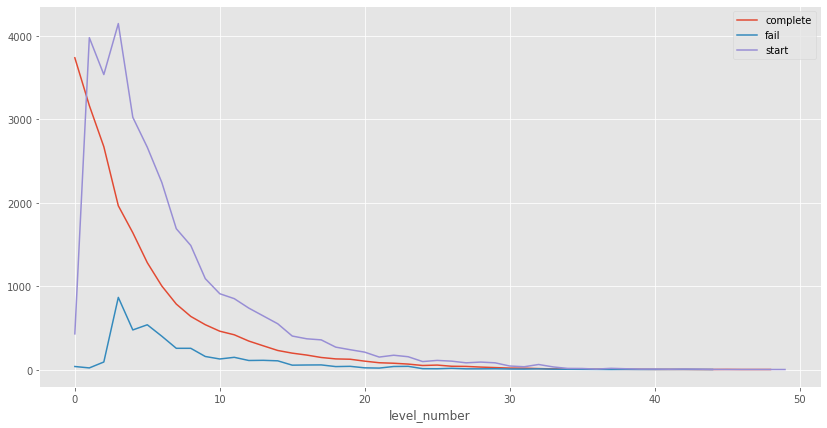

In [7]:

plt.figure(figsize = (14,7))
grouped = df.groupby(['level_number', 'status'])['player_id'].count().reset_index()
grouped.set_index('level_number', inplace = True)
grouped.groupby('status')['player_id'].plot(legend = True)

For a particular level, there can be following possibilities<br>
- start, complete.<br>
- start, fail.<br>
- only start. (might left in midway)<br>

Around level 3, 4, 5, 6 there is significant spikes in the number of starts & fails.<br>
From there on, the numbers have reduced logarthmic fashion.<br>

I guess one or more of the above levels are significantly difficult than user anticipated.

## Filtering data
### Why start events are not needed ?

They are not needed for our objective to determine the levels those users are most likely to fail.<br>
Start by itself wont represent complete event,
it must either complete/fail events succeding it to record whether the attempt is success/failure.

In [8]:

outcome_df = df.loc[df.status != 'start'].copy()
outcome_df.shape



(24717, 5)

In [9]:
ct = pd.crosstab(outcome_df['level_number'], outcome_df['status'])
print(ct.head())
print('\n')
print(ct.tail())

status        complete  fail
level_number                
0                 3736    37
1                 3164    20
2                 2671    91
3                 1963   865
4                 1640   475


status        complete  fail
level_number                
44                   1     1
45                   2     0
46                   1     0
47                   1     0
48                   1     0


Not even single person completed level 49. (only started once)


The frequencies/observations are very low & negligible for all levels > 30.

In [10]:

ct_norm = pd.crosstab(outcome_df['level_number'],outcome_df['status'],normalize = 'index').reset_index()
ct_norm['total_samples'] = ct['complete'] + ct['fail']
ct_norm.sort_values('complete').head()

status,level_number,complete,fail,total_samples
44,44,0.500000,0.500000,2
42,42,0.500000,0.500000,4
35,35,0.571429,0.428571,7
32,32,0.571429,0.428571,21
38,38,0.600000,0.400000,5


If we go by simple success/failure ratio, 
we can say level 44/42 are having high failure rates, but how significant & consistent ? <br>
bcz they have very less samples (< 5). It was the case will all most all levels greather than 10.

So we need to measure statistically & only take the comparisons 
that are satistically significant at certain level.
(alpha = 0.05)

### why does this statistical analysis even matter ?
- As a game publisher,we need to have as more active users as possible which inturn to boost/maintain revenue.<br>
- Some levels which are significantly having lesser success rate indicate that user are finding difficult to get past them & they eventually leave/uninstall the game. <br>
- It could also mean that users are loosing interest in the game or could be due to affect of other factors.

So It is important to identify a lower level which is significantly diffcult than higher levels, as higher ones come later in the game.

### What to do ? If a level with significant low success ratio is identified ?
- Offering some booster/extra lifes for the levels which are having significantly lower success rates will help.<br>
- Reassessing the difficulty of level from user prespective & reordering them will also help.<br>
- Any other steps neccessarily to motivate the user & retain them.

In [13]:
#Set the Significance level
#alpha = 0.05

def get_significance(p_val):
    """Receives the p-value and returns string."""
    if not pd.notnull(p_val):
        p_text = 'ns' 
    elif p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    else:
        p_text = 'significant'
    
    return p_text

### ChiSquare test for proportions.
To check if there is significant association between level_number & status (success/fail).
- H0 (Null hypotheses) : The two categorical variables are independent (no association between the two variables) ( H0: Oi = Ei ).
- H1 (Alternative hypotheses) = The two categorical variables are dependent (there is an association between the two variables) ( Ha: Oi ≠ Ei ).

### Assumptions:
- The two variables are categorical (nominal) and data is randomly sampled.
- The levels of variables are mutually exclusive.
- The expected frequency count for at least 80% of the cell in a contingency table is at least 5.
- The expected frequency count should not be less than 1.
- Observations should be independent of each other.
- Observation data should be frequency counts and not percentages or transformed data.

In [16]:
levels_to_consider = ct_norm[ct_norm['total_samples'] > 5]['level_number'].tolist()

In [23]:
ct_chi = ct[ct.index.isin(levels_to_consider)].copy()


consider only the levels with atleast 10 samples. <br>
As chisqaure wont handle samller samples & will result in errors

In [18]:
chi2, p, dof, exp = stats.chi2_contingency(ct, correction=False)
print('p-value for chi-sqaure test:', p)

p-value for chi-sqaure test: 0.0


- As p-values are less than (<) 0.05, safely reject the null hypothesis.<br>

- There is significant dependence b/w the level_number & status. <br>
Now we need to find which level_number(s) are contributing to this
#### Chisquare test - Post Hoc Analysis (Pairwise tests)
- Post-Hoc Analysis to identify the different level pairs with siginificant difference in ratio of success.

In [24]:
ct_chi['total_samples'] = ct_chi['complete'] + ct_chi['fail']

In [25]:
from statsmodels.stats.proportion import proportions_chisquare_allpairs
r = proportions_chisquare_allpairs(ct_chi['complete'], ct_chi['total_samples'], 
                                   multitest_method = 'simes-hochberg')

g = [eval(t) for t in r.all_pairs_names]
g1, g2 = zip(*g)
rows = list(zip(g1, g2, r.pvals_raw, r.pval_corrected()))
rdf = pd.DataFrame(rows, columns = ['level_1', 'level_2', 'raw_pvalue', 'correct_pvalue'])
rdf.shape

(630, 4)

In [26]:
rdf['result'] = rdf['correct_pvalue'].apply(lambda x:get_significance(x))

In [27]:
sd = dict(zip(ct_norm['level_number'], ct_norm['complete']))

In [28]:
sig_df = rdf[rdf['result'] == 'significant'].copy()
sig_df['level1_success_ratio'] = sig_df['level_1'].replace(sd)
sig_df['level2_success_ratio'] = sig_df['level_2'].replace(sd)
sig_df['diff'] = (sig_df['level1_success_ratio'] - sig_df['level2_success_ratio'])

In [29]:
sig_df.sort_values('correct_pvalue')

,level_1,level_2,raw_pvalue,correct_pvalue,result,level1_success_ratio,level2_success_ratio,diff
2,0,3,3.713181e-263,2.339304e-260,significant,0.990193,0.694130,0.296063
4,0,5,3.560892e-238,2.239801e-235,significant,0.990193,0.704620,0.285573
36,1,3,7.275200e-235,4.568826e-232,significant,0.993719,0.694130,0.299588
5,0,6,3.132988e-220,1.964383e-217,significant,0.990193,0.714693,0.275500
38,1,5,1.464937e-214,9.170505e-212,significant,0.993719,0.704620,0.289098
...,...,...,...,...,...,...,...,...
91,2,25,1.495461e-07,7.955851e-05,significant,0.967053,0.843750,0.123303
134,4,5,4.116511e-07,2.185867e-04,significant,0.775414,0.704620,0.070793
108,3,10,1.378216e-05,7.304542e-03,significant,0.694130,0.783646,-0.089516
107,3,9,3.150175e-05,1.666443e-02,significant,0.694130,0.774101,-0.079971


In [30]:
sig_df[sig_df['diff'] < 0]

,level_1,level_2,raw_pvalue,correct_pvalue,result,level1_success_ratio,level2_success_ratio,diff
102,3,4,2.007675e-10,1.078121e-07,significant,0.69413,0.775414,-0.081284
107,3,9,3.150175e-05,1.666443e-02,significant,0.69413,0.774101,-0.079971
108,3,10,1.378216e-05,7.304542e-03,significant,0.69413,0.783646,-0.089516


### Chisquare Test: What are the levels, users most likely to fail ?
- After sorting the results by p_value, the pair (0,3) is the most significant one rejecting the null hypothesis with highest probability.<br>
So we can users are more likely to fail at level 3 than level 0.

- Also, If we look at pairs with negative effect (diff): we can say success ratio of level 3 is significantly less than level 4, 9 & 10.<br>
The pattern here is not expected or normal,indicating that players are more likely to fail at level 3.<br>

### Fischer's Excat Test
#### why ?
- It relaxes the some assumptions made by the chisquare test & also is works better with lower sample sizes as this a excat test.

In [31]:
from itertools import combinations
import scipy.stats as stats


all_combinations = list(combinations(ct.index, 2))

pairs = []
p_vals = []
odds_ratios = []
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    sdf = ct[(ct.index == comb[0]) | (ct.index == comb[1])]
    oddsratio, pvalue = stats.fisher_exact(sdf)
    pairs.append((comb[0], comb[1]))
    p_vals.append(pvalue)
    odds_ratios.append(oddsratio)
    
len(pairs), len(p_vals)


(1176, 1176)

In [32]:
from statsmodels.sandbox.stats.multicomp import multipletests #fdr_bh
reject_list, corrected_p_vals = multipletests(p_vals, method='simes-hochberg')[:2]

In [33]:
g1, g2 = zip(*pairs)
rows = list(zip(g1, g2, p_vals, corrected_p_vals))
rdf = pd.DataFrame(rows, columns = ['level_1', 'level_2', 'raw_pvalue', 'correct_pvalue'])
rdf['odds_ratio'] = odds_ratios
rdf.shape

(1176, 5)

In [34]:
rdf['result'] = rdf['correct_pvalue'].apply(lambda x:get_significance(x))

In [35]:
sig_df = rdf[rdf['result'] == 'significant'].copy()
sig_df['level1_success_rate'] = sig_df['level_1'].replace(sd)
sig_df['level2_success_rate'] = sig_df['level_2'].replace(sd)
sig_df['diff'] = (sig_df['level1_success_rate'] - sig_df['level2_success_rate'])

In [36]:
sig_df.sort_values('correct_pvalue').head(10)

,level_1,level_2,raw_pvalue,correct_pvalue,odds_ratio,result,level1_success_rate,level2_success_rate,diff
2,0,3,1.257053e-298,1.478295e-295,44.493949,significant,0.990193,0.694130,0.296063
49,1,3,1.041188e-283,1.223395e-280,69.711156,significant,0.993719,0.694130,0.299588
4,0,5,8.014031e-236,9.408472e-233,42.328249,significant,0.990193,0.704620,0.285573
51,1,5,1.004442e-228,1.178210e-225,66.318033,significant,0.993719,0.704620,0.289098
5,0,6,4.232111e-198,4.960035e-195,40.308572,significant,0.990193,0.714693,0.275500
52,1,6,8.766101e-195,1.026510e-191,63.153693,significant,0.993719,0.714693,0.279025
95,2,3,1.325835e-182,1.551227e-179,12.933864,significant,0.967053,0.694130,0.272923
3,0,4,9.363306e-178,1.094571e-174,29.245221,significant,0.990193,0.775414,0.214780
50,1,4,5.065975e-174,5.917059e-171,45.820122,significant,0.993719,0.775414,0.218305
54,1,8,1.750812e-154,2.043198e-151,63.329670,significant,0.993719,0.714126,0.279593


In [37]:
sig_df[sig_df['diff'] < 0]

,level_1,level_2,raw_pvalue,correct_pvalue,odds_ratio,result,level1_success_rate,level2_success_rate,diff
141,3,4,1.786759e-10,1.969009e-07,0.657285,significant,0.69413,0.775414,-0.081284
146,3,9,2.613853e-05,2.825575e-02,0.662249,significant,0.69413,0.774101,-0.079971
147,3,10,1.054741e-05,1.143339e-02,0.626542,significant,0.69413,0.783646,-0.089516


### Fisher Excat Test: What are the levels, users most likely to fail ?¶
- The results are inline with the observations from the chisquare test